# Home Exercise 1 on Text Classification
- Implement a Recurrent Neural Network model (Vanilla RNN, GRU, and LSTM) to predict whether a review is positive or negative.

- Data: IMDB Dataset of 50K Movie Reviews (the last 10% of rows serve as the test set).


- Compare the performance of the three models.

# Library import and using pytorch framework

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


# Data downloading

In [2]:
!gdown 1Rd2BwBSoh7BW9YpMj3wG5hmWjWH7MdPC -O imdb.zip
!unzip imdb.zip "IMDB Dataset".csv

Downloading...
From (original): https://drive.google.com/uc?id=1Rd2BwBSoh7BW9YpMj3wG5hmWjWH7MdPC
From (redirected): https://drive.google.com/uc?id=1Rd2BwBSoh7BW9YpMj3wG5hmWjWH7MdPC&confirm=t&uuid=f4c1d58e-eb7f-4f88-99b2-f25ab08141e6
To: /kaggle/working/imdb.zip
100%|███████████████████████████████████████| 27.0M/27.0M [00:00<00:00, 178MB/s]
Archive:  imdb.zip
  inflating: IMDB Dataset.csv        


In [3]:
# Load IMDB dataset from Kaggle CSV file
def load_imdb_dataset():

    
    # For Kaggle, assuming the dataset is already available in the input folder
    print("Loading IMDB dataset from CSV...")
    
    # Load the dataset
    df = pd.read_csv('IMDB Dataset.csv')
    
    # Display sample data
    print(f"Dataset shape: {df.shape}")
    print(df.head())
    
    # Map sentiment to binary labels
    df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
    
    # Split into train (90%) and test (10%) - using the LAST 10% for test as specified
    total_rows = len(df)
    test_size = int(total_rows * 0.1)
    
    # Get the first 90% for training
    train_df = df.iloc[:-test_size]
    
    # Get the last 10% for testing
    test_df = df.iloc[-test_size:]
    
    print(f"Training set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Extract texts and labels
    train_texts = train_df['review'].values
    train_labels = train_df['sentiment'].values
    test_texts = test_df['review'].values
    test_labels = test_df['sentiment'].values
    
    return train_texts, train_labels, test_texts, test_labels

# Load data
train_texts, train_labels, test_texts, test_labels = load_imdb_dataset()

Loading IMDB dataset from CSV...
Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Training set size: 45000
Test set size: 5000


# Preprocessing data

In [4]:
# Clean and preprocess text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# PyTorch tokenizer implementation to replace Keras Tokenizer
class SimpleTokenizer:
    def __init__(self, num_words=None, oov_token='<OOV>'):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_index = {}
        self.index_word = {}
        self.word_counts = {}
        self.word_docs = {}
        self.document_count = 0
        
    def fit_on_texts(self, texts):
        # Count words
        for text in texts:
            self.document_count += 1
            words = text.split()
            for word in words:
                if word in self.word_counts:
                    self.word_counts[word] += 1
                else:
                    self.word_counts[word] = 1
                
                if word in self.word_docs:
                    self.word_docs[word] += 1
                else:
                    self.word_docs[word] = 1
        
        # Sort words by frequency
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Create word_index
        self.word_index = {self.oov_token: 1}  # 0 reserved for padding
        idx = 2
        for word, count in sorted_words:
            if self.num_words and idx >= self.num_words:
                break
            self.word_index[word] = idx
            self.index_word[idx] = word
            idx += 1
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = text.split()
            seq = []
            for word in words:
                if word in self.word_index:
                    seq.append(self.word_index[word])
                else:
                    seq.append(self.word_index[self.oov_token])
            sequences.append(seq)
        return sequences

# Pad sequences function
def pad_sequences(sequences, maxlen=None, padding='post'):
    if maxlen is None:
        maxlen = max(len(seq) for seq in sequences)
    
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            padded_seq = seq[:maxlen]
        else:
            padded_seq = seq + [0] * (maxlen - len(seq)) if padding == 'post' else [0] * (maxlen - len(seq)) + seq
        padded_sequences.append(padded_seq)
    
    return np.array(padded_sequences)

# Preprocess the data
def preprocess_data(train_texts, train_labels, test_texts, test_labels, max_features=10000, max_len=200):
    # Clean texts
    train_texts = [clean_text(text) for text in train_texts]
    test_texts = [clean_text(text) for text in test_texts]
    
    # Tokenize texts
    tokenizer = SimpleTokenizer(num_words=max_features, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_texts)
    
    # Convert texts to sequences
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_test = tokenizer.texts_to_sequences(test_texts)
    
    # Pad sequences
    x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
    x_test = pad_sequences(x_test, maxlen=max_len, padding='post')
    
    # Get vocabulary size
    vocab_size = min(max_features, len(tokenizer.word_index) + 1)
    print(f"Vocabulary size: {vocab_size}")
    
    # Convert to PyTorch tensors
    x_train = torch.LongTensor(x_train)
    y_train = torch.FloatTensor(train_labels)
    x_test = torch.LongTensor(x_test)
    y_test = torch.FloatTensor(test_labels)
    
    return x_train, y_train, x_test, y_test, vocab_size


# Preprocess data
max_features = 10000  # Maximum number of words in vocabulary
max_len = 200  # Maximum sequence length

print(f"\nPreprocessing data with max sequence length of {max_len}...")
x_train, y_train, x_test, y_test, vocab_size = preprocess_data(
    train_texts, train_labels, test_texts, test_labels, max_features, max_len
)


Preprocessing data with max sequence length of 200...
Vocabulary size: 10000


# Model define

In [5]:
# PyTorch models using Sequential API
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_units=128, num_layers=1, dropout=0.5):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_units, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = output[:, -1, :]  # Get last timestep output
        output = self.dropout(output)
        output = self.fc(output)
        return self.sigmoid(output.squeeze())

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_units=128, num_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_norm = nn.LayerNorm(embedding_dim)  # LayerNorm sau Embedding
        self.lstm = nn.LSTM(embedding_dim, hidden_units, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.lstm_norm = nn.LayerNorm(hidden_units)  # LayerNorm sau LSTM
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        x = self.embedding_norm(x)  # LayerNorm sau Embedding
        output, _ = self.lstm(x)  # LSTM layer
        output = self.lstm_norm(output[:, -1, :])  # LayerNorm sau LSTM (lấy output cuối cùng)
        output = self.dropout(output)  # Dropout
        output = self.fc(output)  # Fully connected layer
        output = self.sigmoid(output)  # Sigmoid activation
        return output

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_units=128, num_layers=2, dropout=0.3):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_norm = nn.LayerNorm(embedding_dim)  # LayerNorm sau Embedding
        self.gru = nn.GRU(embedding_dim, hidden_units, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.gru_norm = nn.LayerNorm(hidden_units)  # LayerNorm sau GRU
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        x = self.embedding_norm(x)  # LayerNorm sau Embedding
        output, _ = self.gru(x)  # GRU layer
        output = self.gru_norm(output[:, -1, :])  # LayerNorm sau GRU (lấy output cuối cùng)
        output = self.dropout(output)  # Dropout
        output = self.fc(output)  # Fully connected layer
        output = self.sigmoid(output)  # Sigmoid activation
        return output

# Train model

In [6]:
# Train function
def train_model(model, x_train, y_train, val_data=None, epochs=10, batch_size=64, learning_rate=0.01):
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Create validation dataset if provided
    if val_data:
        x_val, y_val = val_data
        x_val = x_val.to(device)
        y_val = y_val.to(device)
    
    # Create data loader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training history
    history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate statistics
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Update progress bar
            loop.set_postfix(loss=loss.item(), acc=correct/total)
        
        # Calculate epoch statistics
        epoch_loss = train_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        # Validation
        if val_data:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                outputs = model(x_val).squeeze()
                val_loss = criterion(outputs, y_val).item()
                val_predicted = (outputs > 0.5).float()
                val_correct = (val_predicted == y_val).sum().item()
                val_total = y_val.size(0)
            
            val_acc = val_correct / val_total
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
            print(f"Epoch {epoch+1}/{epochs}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
            
            # # Early stopping
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     patience_counter = 0
            #     best_model_state = model.state_dict().copy()
            # else:
            #     patience_counter += 1
            #     if patience_counter >= patience:
            #         print(f"Early stopping at epoch {epoch+1}")
            #         model.load_state_dict(best_model_state)
            #         break
        else:
            print(f"Epoch {epoch+1}/{epochs}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")
    
    return history

# Train and evaluate model
def train_and_evaluate(model, x_train, y_train, x_test, y_test, model_name, epochs=5, batch_size=64):
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Split training data for validation (10%)
    val_size = int(len(x_train) * 0.1)
    x_val = x_train[-val_size:].to(device)
    y_val = y_train[-val_size:].to(device)
    x_train = x_train[:-val_size].to(device)
    y_train = y_train[:-val_size].to(device)
    
    # Train the model
    history = train_model(
        model, x_train, y_train, 
        val_data=(x_val, y_val),
        epochs=epochs, 
        batch_size=batch_size
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"{model_name} training completed in {training_time:.2f} seconds")
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_pred_proba = model(x_test).cpu().numpy()
        y_pred = (y_pred_proba > 0.5).astype(int)
        y_test = y_test.cpu().numpy()
    
    # Print metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.close()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'training_time': training_time,
        'history': history
    }

In [7]:
# Build models
print("\nBuilding models...")
vanilla_rnn = VanillaRNN(vocab_size, embedding_dim=128, hidden_units=64, num_layers=2, dropout=0.3)
gru_model = GRUModel(vocab_size, embedding_dim=256, hidden_units=76, num_layers=2, dropout=0.3)
lstm_model = LSTMModel(vocab_size, embedding_dim=128, hidden_units=64, num_layers=2, dropout=0.3)


Building models...


In [8]:
# Train and evaluate models
results = []

# Vanilla RNN
vanilla_results = train_and_evaluate(
    vanilla_rnn, x_train, y_train, x_test, y_test, 
    "Vanilla RNN", epochs = 10, batch_size = 256
)
results.append(vanilla_results)

# GRU
gru_results = train_and_evaluate(
    gru_model, x_train, y_train, x_test, y_test, 
    "GRU", epochs = 10, batch_size = 232
)
results.append(gru_results)

# LSTM
lstm_results = train_and_evaluate(
    lstm_model, x_train, y_train, x_test, y_test, 
    "LSTM", epochs = 10, batch_size = 128
)
results.append(lstm_results)


Training Vanilla RNN...


Epoch 1/10: 100%|██████████| 159/159 [00:01<00:00, 87.08it/s, acc=0.504, loss=0.719] 


Epoch 1/10: loss=0.6999, acc=0.5037, val_loss=0.6938, val_acc=0.5053


Epoch 2/10: 100%|██████████| 159/159 [00:01<00:00, 139.35it/s, acc=0.497, loss=0.689]


Epoch 2/10: loss=0.6971, acc=0.4968, val_loss=0.6934, val_acc=0.5047


Epoch 3/10: 100%|██████████| 159/159 [00:01<00:00, 140.58it/s, acc=0.501, loss=0.709]


Epoch 3/10: loss=0.6974, acc=0.5005, val_loss=0.6970, val_acc=0.4951


Epoch 4/10: 100%|██████████| 159/159 [00:01<00:00, 137.10it/s, acc=0.501, loss=0.724]


Epoch 4/10: loss=0.6970, acc=0.5006, val_loss=0.6965, val_acc=0.4971


Epoch 5/10: 100%|██████████| 159/159 [00:01<00:00, 140.30it/s, acc=0.502, loss=0.687]


Epoch 5/10: loss=0.6994, acc=0.5015, val_loss=0.6940, val_acc=0.5029


Epoch 6/10: 100%|██████████| 159/159 [00:01<00:00, 141.39it/s, acc=0.507, loss=0.681]


Epoch 6/10: loss=0.6971, acc=0.5074, val_loss=0.7005, val_acc=0.4991


Epoch 7/10: 100%|██████████| 159/159 [00:01<00:00, 124.50it/s, acc=0.512, loss=0.687]


Epoch 7/10: loss=0.6959, acc=0.5116, val_loss=0.7013, val_acc=0.5093


Epoch 8/10: 100%|██████████| 159/159 [00:01<00:00, 140.49it/s, acc=0.523, loss=0.713]


Epoch 8/10: loss=0.6926, acc=0.5227, val_loss=0.6940, val_acc=0.5138


Epoch 9/10: 100%|██████████| 159/159 [00:01<00:00, 141.16it/s, acc=0.526, loss=0.695]


Epoch 9/10: loss=0.6930, acc=0.5255, val_loss=0.7005, val_acc=0.5144


Epoch 10/10: 100%|██████████| 159/159 [00:01<00:00, 140.12it/s, acc=0.539, loss=0.684]


Epoch 10/10: loss=0.6863, acc=0.5390, val_loss=0.6988, val_acc=0.5142
Vanilla RNN training completed in 16.15 seconds
Vanilla RNN Test Accuracy: 0.5154

Classification Report for Vanilla RNN:
              precision    recall  f1-score   support

         0.0       0.51      0.84      0.64      2530
         1.0       0.53      0.18      0.27      2470

    accuracy                           0.52      5000
   macro avg       0.52      0.51      0.45      5000
weighted avg       0.52      0.52      0.45      5000


Training GRU...


Epoch 1/10: 100%|██████████| 175/175 [00:03<00:00, 46.05it/s, acc=0.649, loss=0.283]


Epoch 1/10: loss=0.5830, acc=0.6493, val_loss=0.3409, val_acc=0.8504


Epoch 2/10: 100%|██████████| 175/175 [00:03<00:00, 46.34it/s, acc=0.88, loss=0.265]


Epoch 2/10: loss=0.2925, acc=0.8797, val_loss=0.2926, val_acc=0.8782


Epoch 3/10: 100%|██████████| 175/175 [00:03<00:00, 46.63it/s, acc=0.914, loss=0.215]


Epoch 3/10: loss=0.2197, acc=0.9142, val_loss=0.3363, val_acc=0.8627


Epoch 4/10: 100%|██████████| 175/175 [00:03<00:00, 46.60it/s, acc=0.934, loss=0.234]


Epoch 4/10: loss=0.1773, acc=0.9341, val_loss=0.3513, val_acc=0.8644


Epoch 5/10: 100%|██████████| 175/175 [00:03<00:00, 44.85it/s, acc=0.944, loss=0.212]


Epoch 5/10: loss=0.1514, acc=0.9445, val_loss=0.3275, val_acc=0.8707


Epoch 6/10: 100%|██████████| 175/175 [00:03<00:00, 46.53it/s, acc=0.946, loss=0.223]


Epoch 6/10: loss=0.1428, acc=0.9460, val_loss=0.3425, val_acc=0.8729


Epoch 7/10: 100%|██████████| 175/175 [00:03<00:00, 46.62it/s, acc=0.95, loss=0.14]


Epoch 7/10: loss=0.1343, acc=0.9505, val_loss=0.3622, val_acc=0.8660


Epoch 8/10: 100%|██████████| 175/175 [00:03<00:00, 46.82it/s, acc=0.952, loss=0.178]


Epoch 8/10: loss=0.1300, acc=0.9523, val_loss=0.3650, val_acc=0.8618


Epoch 9/10: 100%|██████████| 175/175 [00:03<00:00, 46.64it/s, acc=0.951, loss=0.156]


Epoch 9/10: loss=0.1310, acc=0.9511, val_loss=0.3967, val_acc=0.8618


Epoch 10/10: 100%|██████████| 175/175 [00:03<00:00, 46.31it/s, acc=0.95, loss=0.143]


Epoch 10/10: loss=0.1316, acc=0.9503, val_loss=0.3553, val_acc=0.8642
GRU training completed in 38.75 seconds
GRU Test Accuracy: 0.8610

Classification Report for GRU:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      2530
         1.0       0.87      0.85      0.86      2470

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


Training LSTM...


Epoch 1/10: 100%|██████████| 317/317 [00:02<00:00, 106.21it/s, acc=0.509, loss=0.717]


Epoch 1/10: loss=0.6956, acc=0.5094, val_loss=0.6685, val_acc=0.5798


Epoch 2/10: 100%|██████████| 317/317 [00:02<00:00, 106.02it/s, acc=0.547, loss=0.751]


Epoch 2/10: loss=0.6781, acc=0.5467, val_loss=0.7345, val_acc=0.4949


Epoch 3/10: 100%|██████████| 317/317 [00:02<00:00, 105.78it/s, acc=0.724, loss=0.308]


Epoch 3/10: loss=0.5205, acc=0.7244, val_loss=0.3801, val_acc=0.8367


Epoch 4/10: 100%|██████████| 317/317 [00:03<00:00, 105.26it/s, acc=0.858, loss=0.325]


Epoch 4/10: loss=0.3377, acc=0.8585, val_loss=0.3372, val_acc=0.8573


Epoch 5/10: 100%|██████████| 317/317 [00:02<00:00, 106.11it/s, acc=0.887, loss=0.407]


Epoch 5/10: loss=0.2806, acc=0.8870, val_loss=0.3261, val_acc=0.8591


Epoch 6/10: 100%|██████████| 317/317 [00:02<00:00, 106.08it/s, acc=0.91, loss=0.205]


Epoch 6/10: loss=0.2367, acc=0.9098, val_loss=0.3421, val_acc=0.8667


Epoch 7/10: 100%|██████████| 317/317 [00:02<00:00, 106.25it/s, acc=0.917, loss=0.339]


Epoch 7/10: loss=0.2152, acc=0.9174, val_loss=0.3258, val_acc=0.8622


Epoch 8/10: 100%|██████████| 317/317 [00:02<00:00, 106.16it/s, acc=0.93, loss=0.103]


Epoch 8/10: loss=0.1889, acc=0.9299, val_loss=0.3770, val_acc=0.8598


Epoch 9/10: 100%|██████████| 317/317 [00:02<00:00, 106.53it/s, acc=0.938, loss=0.183]


Epoch 9/10: loss=0.1699, acc=0.9376, val_loss=0.3422, val_acc=0.8640


Epoch 10/10: 100%|██████████| 317/317 [00:03<00:00, 104.52it/s, acc=0.944, loss=0.204]


Epoch 10/10: loss=0.1555, acc=0.9436, val_loss=0.3363, val_acc=0.8582
LSTM training completed in 30.51 seconds
LSTM Test Accuracy: 0.8628

Classification Report for LSTM:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      2530
         1.0       0.87      0.85      0.86      2470

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



# Compare model


Model Comparison:
         Model  Accuracy  Training Time (s)
0  Vanilla RNN    0.5154          16.147670
1          GRU    0.8610          38.754853
2         LSTM    0.8628          30.511316


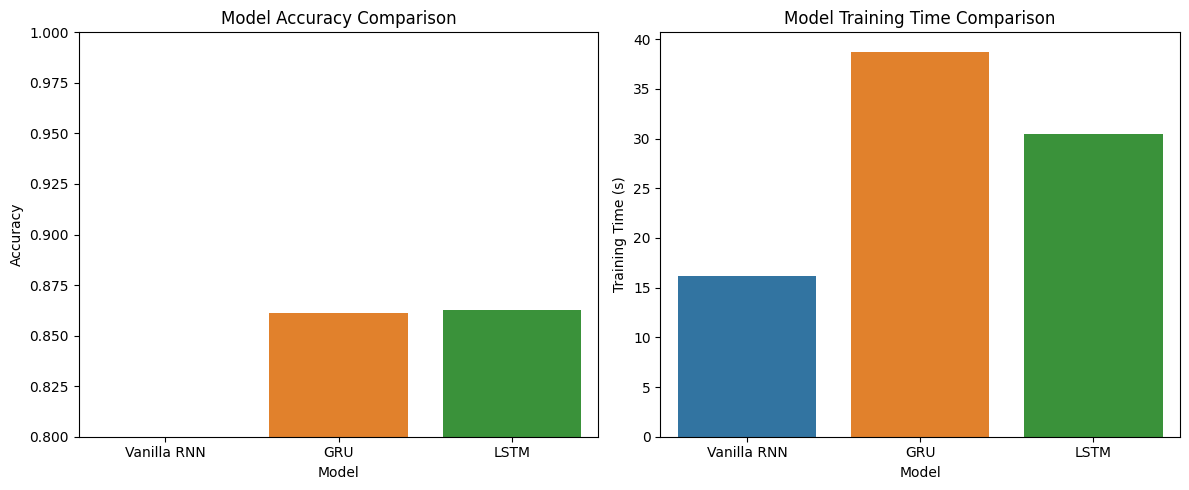

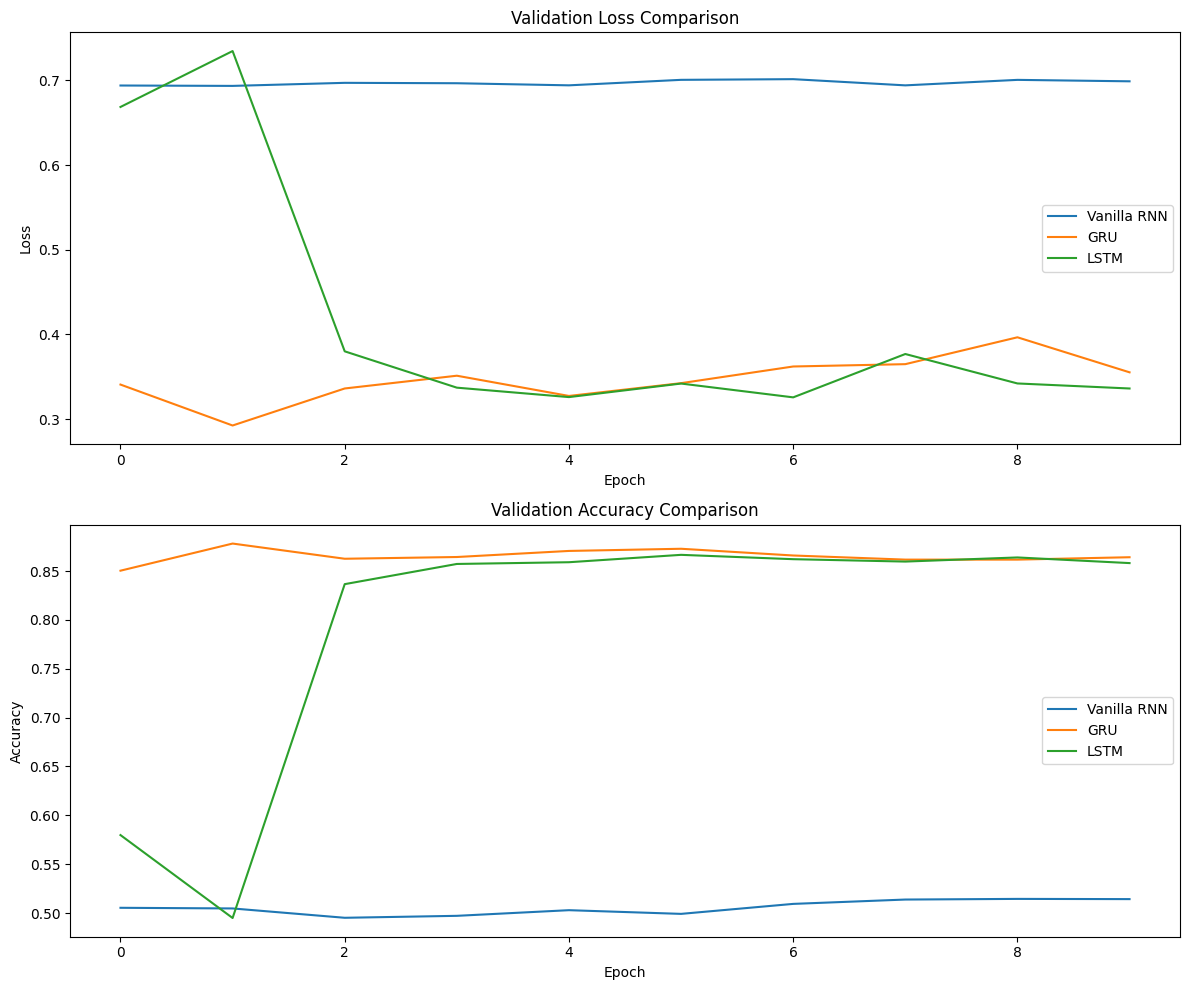


Experiment complete!


In [9]:
# Compare models
def compare_models(results):
    # Extract data for comparison
    model_names = [result['model_name'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    training_times = [result['training_time'] for result in results]
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies,
        'Training Time (s)': training_times
    })
    print("\nModel Comparison:")
    print(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    # Accuracy comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='Accuracy', data=comparison_df)
    plt.title('Model Accuracy Comparison')
    plt.ylim(0.8, 1.0)  # Adjust as needed
    
    # Training time comparison
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Training Time (s)', data=comparison_df)
    plt.title('Model Training Time Comparison')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    
    return comparison_df

# Plot learning curves for all models
def plot_learning_curves(results):
    plt.figure(figsize=(12, 10))
    
    # Loss comparison
    plt.subplot(2, 1, 1)
    for result in results:
        plt.plot(result['history']['val_loss'], label=f"{result['model_name']}")
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy comparison
    plt.subplot(2, 1, 2)
    for result in results:
        plt.plot(result['history']['val_accuracy'], label=f"{result['model_name']}")
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('learning_curves_comparison.png')
    plt.show()

# Compare models
comparison = compare_models(results)

# Plot learning curves
plot_learning_curves(results)

print("\nExperiment complete!")

# Key Observations

**Accuracy Performance:**

- The Vanilla RNN significantly underperforms compared to GRU and LSTM models.
  
- Vanilla RNNs struggle with **long-term dependencies** due to vanishing gradients, while GRUs/LSTMs use **gating mechanisms** to retain key information, achieving significantly better performance.

**Training Time:**

- Vanilla RNN has the shortest training time.
  
- GRU takes the longest to train.
  
- LSTM falls in between those 2 above.


**Validation Metrics:**

- The validation loss graph shows more stability for Vanilla RNN.
- GRU and LSTM show more fluctuations but generally maintain lower loss values.
- The validation accuracy graph reveals that GRU and LSTM quickly reach and maintain high accuracy, while Vanilla RNN remains low.

For the **IMDB movie review sentiment analysis task** (binary classification), **LSTM** is the best choice overall—it handles long-range dependencies in text effectively. **GRU** is a close second, offering similar accuracy with slightly faster training. The **Vanilla RNN** is not recommended due to poor performance with long reviews.

Prioritize: **LSTM > GRU** (if speed is critical) >> **Vanilla RNN** (avoid for this task).